In [4]:
#%tensorflow_version 1.14
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [5]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=NGN&limit=1000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'


In [6]:
hist.head(1000)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2018-04-27,3401110.49,3034374.13,3289582.21,184.75,6.103485e+08,3126600.35,direct,
2018-04-28,3398542.07,3172900.01,3189910.75,121.10,4.003565e+08,3297446.24,direct,
2018-04-29,3417804.86,3284121.55,3297446.24,89.76,3.011577e+08,3362741.40,direct,
2018-04-30,3391125.54,3320862.71,3362741.40,91.41,3.052090e+08,3341999.81,direct,
2018-05-01,3359627.49,3262824.00,3341984.93,99.82,3.266657e+08,3283400.00,direct,
...,...,...,...,...,...,...,...,...
2021-01-16,18347222.69,17124574.73,17844014.41,614.12,1.095922e+10,17427361.27,direct,
2021-01-17,17781514.70,16530497.27,17427361.27,531.57,9.154893e+09,17324402.56,direct,
2021-01-18,18000577.98,16906387.76,17324402.56,560.83,9.811468e+09,17631256.90,direct,


In [19]:
hist.drop('conversionType',inplace=True,axis=1)
hist.drop('conversionSymbol',inplace=True,axis=1)

In [20]:
for col in hist.columns: 
    print(col) 

high
low
open
volumefrom
volumeto
close


In [21]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train,test = train_test_split(hist, test_size=0.2)

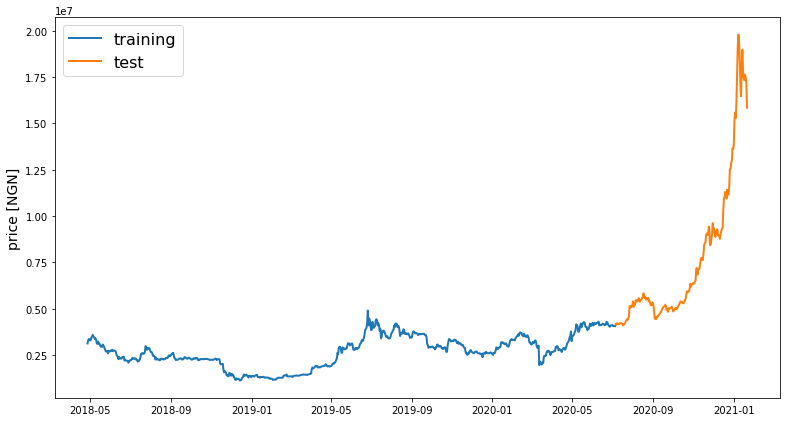

In [22]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [NGN]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [23]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [24]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [25]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [26]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [27]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [28]:
train.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2018-04-27,3401110.49,3034374.13,3289582.21,184.75,6.103485e+08,3126600.35
2018-04-28,3398542.07,3172900.01,3189910.75,121.10,4.003565e+08,3297446.24
2018-04-29,3417804.86,3284121.55,3297446.24,89.76,3.011577e+08,3362741.40
2018-04-30,3391125.54,3320862.71,3362741.40,91.41,3.052090e+08,3341999.81
2018-05-01,3359627.49,3262824.00,3341984.93,99.82,3.266657e+08,3283400.00


In [29]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [30]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
25/25 [==============================] - 4s 9ms/step - loss: 0.0090
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 9/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 11/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 12/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 13/50
25/25 [==============================

## Metrics

In [39]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
#print('MAE='mean_absolute_error(preds, y_test)
print('Mean Absolute Error: {}'.format(mean_absolute_error(preds, y_test)))

Mean Absolute Error: 0.02373932529537589


In [40]:
print('Mean Squared Error: {}'.format(mean_squared_error(preds, y_test)))

Mean Squared Error: 0.0013245429897462717


In [43]:
from math import sqrt
root_mean_squared_error = sqrt(mean_squared_error(preds, y_test))
print('Root Mean Squared Error: {}'.format(root_mean_squared_error))

Root Mean Squared Error: 0.036394271386390904


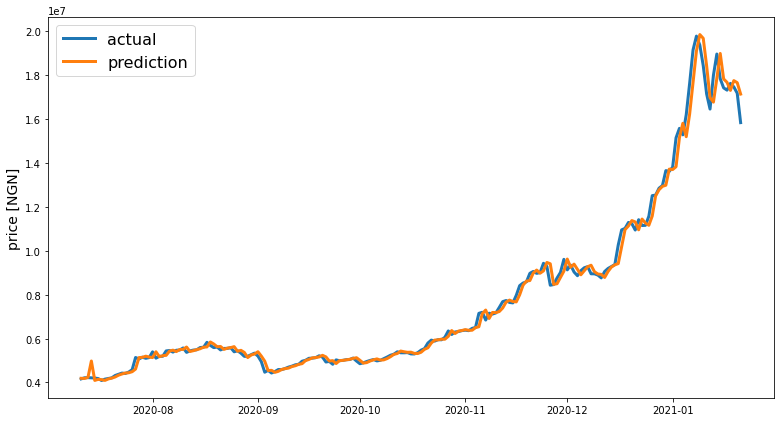

In [32]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [33]:
def mean_absolute_percentage_error(targets, preds):
    y_true, y_pred = np.array(targets), np.array(preds)
    return np.mean(np.abs((targets - preds) / targets)) * 100
mean_absolute_percentage_error(preds, targets)

2.2638392097229256